<a href="https://colab.research.google.com/github/basel5621/depi-project/blob/main/training_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.tokenize import word_tokenize
from gensim.models import Word2Vec
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
df_train = pd.read_csv('/content/drive/MyDrive/dataset/train.csv',encoding="ISO-8859-1")

In [ ]:
df_train.drop(columns=['Unnamed: 0'],inplace=True)

In [ ]:
df_train.head()

,cleaned_text,label
0,going another signing north cause live blackpo...,0
1,cowardly loser seek racism weapon not win,1
2,checking much talked twitter thanks jen,1
3,feel hot im kind getty coughy scratchy throat,0
4,yay emily twitter exciting hope summer going w...,1


In [ ]:
X=df_train['cleaned_text'].astype(str)
y=df_train['label']

X.info()

<class 'pandas.core.series.Series'>
RangeIndex: 1440000 entries, 0 to 1439999
Series name: cleaned_text
Non-Null Count    Dtype 
--------------    ----- 
1440000 non-null  object
dtypes: object(1)
memory usage: 11.0+ MB


In [ ]:
X_token=X.apply(word_tokenize)
model_w2v = Word2Vec(X_token, vector_size=300, window=5, min_count=1, workers=4, sg=0)

In [ ]:
print(model_w2v.wv.most_similar('happy'))

[('proud', 0.5638808608055115), ('celebrating', 0.5416862368583679), ('marstinis', 0.5183213353157043), ('exciiiiteeeeedddd', 0.5125848054885864), ('tomarra', 0.5114507079124451), ('graduationsomething', 0.5111462473869324), ('alysias', 0.507931649684906), ('bastille', 0.5044581890106201), ('knightmay', 0.5034371018409729), ('michis', 0.5012421011924744)]


In [ ]:
model_w2v.save("/content/drive/MyDrive/models/word2vec.model")

In [ ]:
loaded_model = Word2Vec.load("word2vec.model")

FileNotFoundError: [Errno 2] No such file or directory: 'word2vec.model'

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)

vocab_size = len(tokenizer.word_index)+1

X_train_seq = tokenizer.texts_to_sequences(X)

max_len = max(len(seq) for seq in X_train_seq)
X_train_padded = pad_sequences(X_train_seq , maxlen=max_len , padding='post')
vocab_size

406547

In [ ]:
missing_words = []
for word, i in tokenizer.word_index.items():
    if word in model_w2v.wv:
        embedding_matrix[i] = model_w2v.wv[word]
    else:
        missing_words.append(word)

print(f"Number of words not found in Word2Vec: {len(missing_words)}")


Number of words not found in Word2Vec: 10447


In [ ]:
from tensorflow.keras import regularizers, callbacks
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense ,Dropout
from tensorflow.keras import layers


BI_LSTM_model2 = Sequential([
    layers.Input(shape=(max_len,)),
    layers.Embedding(input_dim=vocab_size, output_dim=model_w2v.vector_size, weights=[embedding_matrix], trainable=False),
    layers.Bidirectional(layers.LSTM(128, return_sequences=True, kernel_regularizer=regularizers.l2(0.01))),
    layers.GlobalMaxPool1D(),
    layers.Dropout(0.3),
    layers.Dense(64, activation="relu", kernel_regularizer=regularizers.l2(0.01)),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')
])

BI_LSTM_model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

BI_LSTM_model2.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 37, 300)             │     121,964,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 37, 256)             │         439,296 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d                 │ (None, 256)                 │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 122,419,909 (466.99 MB)

 Trainable params: 455,809 (1.74 MB)

 Non-trainable params: 121,964,100 (465.26 MB)

In [ ]:
BI_history2=BI_LSTM_model2.fit(X_train_padded, y, epochs=100, batch_size=512, validation_split=0.1,callbacks=[early_stopping])

Epoch 1/100
2532/2532 ━━━━━━━━━━━━━━━━━━━━ 77s 30ms/step - accuracy: 0.7596 - loss: 1.0000 - val_accuracy: 0.7749 - val_loss: 0.4909
Epoch 2/100
2532/2532 ━━━━━━━━━━━━━━━━━━━━ 82s 30ms/step - accuracy: 0.7772 - loss: 0.4873 - val_accuracy: 0.7777 - val_loss: 0.4804
Epoch 3/100
2532/2532 ━━━━━━━━━━━━━━━━━━━━ 82s 30ms/step - accuracy: 0.7775 - loss: 0.4847 - val_accuracy: 0.7783 - val_loss: 0.4786
Epoch 4/100
2532/2532 ━━━━━━━━━━━━━━━━━━━━ 83s 30ms/step - accuracy: 0.7797 - loss: 0.4808 - val_accuracy: 0.7837 - val_loss: 0.4720
Epoch 5/100
2532/2532 ━━━━━━━━━━━━━━━━━━━━ 76s 30ms/step - accuracy: 0.7807 - loss: 0.4797 - val_accuracy: 0.7816 - val_loss: 0.4752
Epoch 6/100
2532/2532 ━━━━━━━━━━━━━━━━━━━━ 81s 30ms/step - accuracy: 0.7812 - loss: 0.4785 - val_accuracy: 0.7756 - val_loss: 0.4873
Epoch 7/100
2532/2532 ━━━━━━━━━━━━━━━━━━━━ 83s 30ms/step - accuracy: 0.7828 - loss: 0.4761 - val_accuracy: 0.7818 - val_loss: 0.4796
Epoch 8/100
2532/2532 ━━━━━━━━━━━━━━━━━━━━ 77s 31ms/step - accuracy: 

<Axes: >

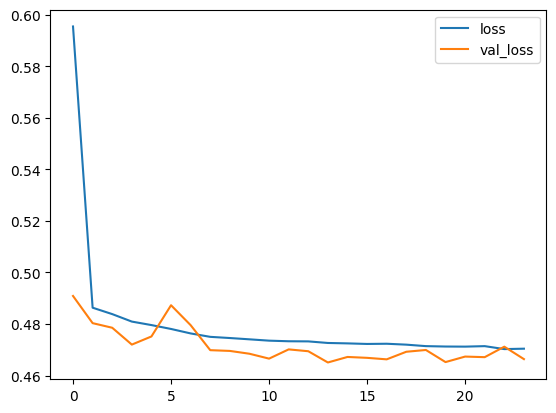

In [ ]:
df_hist_BI2=pd.DataFrame(BI_history2.history)
df_hist_BI2[['loss','val_loss']].plot()